# Generation of the Faux data with Zemax PSFs

### Plan of attack:
1. Generate data with Zemax PSFs that perturbs the field angle, separation and contrast of Alpha Cen A and B
    - Note it is important to add some noise to these images to prevent the fitting algorithms from getting stuck
    - As a start point try simply adding read noise from the detector
2. Use a least squares fit from models generated with Fourier Transforms to fit these parameters
    - Don't forget to add a sensical termination point
3. See how much a perturbation in the faux data ($\Delta x_f$) translates to a a perturbation in the model ($\Delta x_r$)
    - We want $\Delta x_f = \alpha \Delta x_r$, ie linear
    - With linearity we can extract our science goal (we only need relative separation, not absolute)

In [1]:
import numpy as np
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
from scipy.optimize import least_squares
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.FT_modelling import *
from lib.synphot import *

In [2]:
# tqdm spacing workaround
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [3]:
# Optical Architecture
aperture = 0.1 # m
central_obscuration = 0.011 # m, diameter
focal_length = 3.635 # m

# CCD Architecture
# detector_size = 2000
# detector_size = 512
detector_size = 200
detector_pitch = 6.5e-6
fps = 7.5
QE = 0.9
read_noise = 1.6
dark_current = 0.68
gain = 1.29
full_well = 95e3

# Zemax settings
zmx_pixel_size = 1.625e-6

In [4]:
# Inputs for pysynphot
nwavels = 1001
wl_range = np.array([545e-9, 645e-9]) # Angstroms

In [5]:
# Stellar Parameters
acenA = {"mag":0.01, 
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30}

acenB = {"mag":1.33, 
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37}

In [6]:
# Create stellar observation object
acenA["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenA)
acenB["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenB)

# Uncomment this to get equal magnitudes (makes it easier to distinguish)
# acenB["obs"] = acenA["obs"]

# Calculate photon rate per second
acenA["rate/s"] = acenA["obs"].countrate() # Has units of counts per second
acenB["rate/s"] = acenB["obs"].countrate() # Has units of counts per second

# Caluate photon rate per frame
acenA["rate/frame"] = acenA["rate/s"]/fps
acenB["rate/frame"] = acenB["rate/s"]/fps

# Calculate the binary separation
acenA["coord"] = SkyCoord("14h39m36.49400s -60d50m02.3737s")
acenB["coord"] = SkyCoord("14h39m35.06311s -60d50m15.0992s")
binary_separation = acenA["coord"].separation(acenB["coord"]).arcsec

In [8]:
print(acenB["rate/s"])

10275148.24652527


In [554]:
#Input the raw the psf from zemax
psf_on_norm_zmx, psf_on_meta_data_zmx = zemax_to_array('files/on-axis_broadband.txt')
psf_off_norm_zmx, psf_off_meta_data_zmx = zemax_to_array('files/off-axis_broadband.txt')

---
# Generation of faux science parameters

In [647]:
num = 5 # Keep this an odd number
N = num//2

---
### Field angle, A:
> We want to perturb this by ~ 1/2 a pixel. 
> 
> The pixel scale is ~0.375 arcseconds per pixels so we want a total perturbation of 0.1875. We need to convert this to a field angle.
>
> $\alpha$ Cen B orbits at a separation of ~16.5 arcsec. Using this as a radius the total orbit is $2\pi * 16.5 ~= 103.5$ arcseconds.
>
> The ratio of the total orbital length we want to perturb by is then $103.5/0.1875 = 1.812e-3$. 
>
> This gives us a total angular perturbation of $2\pi * 1.812e-3 = 0.0114$ or +- $5.7e-3$ radians.
>
> Spread over 5 positions this gives a $\Delta$A = $1.14e-3$ radians.
    

In [648]:
central_A = 0
# delta_A = 1.14e-3 # radians
delta_A = -np.pi/2**8 # radians
# delta_A = -np.pi/2**4 # radians
start = central_A - N*delta_A
end = central_A + N*delta_A
field_angles = np.linspace(start, end, num=num, dtype=np.float64)

print(100*field_angles/2*np.pi)

[ 3.85531422  1.92765711  0.         -1.92765711 -3.85531422]


---
### Binary separation, B:
> We want to perturb this in the micro-arcsecond regieme.
>
> For a start we will perturb linearly by +- 5 micro-arcseconds over 5 positions for a $\Delta$B = 2 $\mu$asec



In [649]:
# AcenB central point at 16.5 arcseconds
central_B = 16.5 # arcseconds
# delta_B = 2e-6
delta_B = 0.05
# delta_B = 1
start = central_B - N*delta_B
end = central_B + N*delta_B
binary_separations = np.linspace(start, end, num=num, dtype=np.float64)

print(binary_separations)

[16.4  16.45 16.5  16.55 16.6 ]


---
### Relative contrast, C:
> For simplicity we will measure contrast as a ratio of count rates from each star
>
> We want a total relative contrast perturbation of ~ 5% over 5 positions for a $\Delta$C of 1%
>
> To shift the relative contrast by $\Delta C$ we want $A_{new} = A + \frac{A*\Delta C}{A/B}$ 

In [650]:
acenA_countrate = acenA["rate/frame"] 
acenB_countrate = acenB["rate/frame"]
ratio = np.round(acenA_countrate/acenB_countrate, decimals=2)

delta_C = 0.2
start = ratio - N*delta_C
end = ratio + N*delta_C
relative_contrasts = np.linspace(start, end, num=num)
delta_Cs = np.linspace(1-(N*delta_C), 1+(N*delta_C), num=num)

print(relative_contrasts)
print(delta_Cs)

# Shift contrasts by changing the brightness of AcenA 
# acenA_countrates_new = [A + (A*delta_C)/(A/B) for delta_C in delta_Cs]
# ratio = A/B
# print(ratio - np.array(acenA_countrates_new)/B)
# print(np.round(acenA_countrates_new))

[3.54 3.74 3.94 4.14 4.34]
[0.6 0.8 1.  1.2 1.4]


---
# Generate the faux data
Using these perturbation parameter we will get 125 false data point with which to try and fit

In [651]:
def generate_data(PSFs, field_angles, binary_separations, delta_Cs, acenA_countrate, acenB_countrate, zmx_pixel_size, im_pixel_size, focal_length, detector_size):
    """
    
    """
    # Get each PSF and normalise it
    PSF_A = PSFs[0]/np.sum(PSFs[0], dtype=np.float64)
    PSF_B = PSFs[1]/np.sum(PSFs[1], dtype=np.float64)
    
    # Calculate the x-y pixel shift coordinates    
    pixel_separations = [arcsec_to_pixel(binary_separations[i], zmx_pixel_size, focal_length) for i in range(len(binary_separations))]
    X,Y = np.meshgrid(field_angles, pixel_separations)
    Ys = Y*np.cos(X, dtype=np.float64)
    Xs = Y*np.sin(X, dtype=np.float64)
    # Note this Xs and Ys values are assigned coutnerintuitively, this is becuase they are the SHIFT values, NOT the coordinates of the PSF

    # Set AcenB offset
    shifted = np.array([ndimage.shift(PSF_B, [Xs[j][i], Ys[j][i]], order=3) for i in range(len(Xs)) for j in range(len(Xs[i]))])
    # Need to test here if order 0 or 1 gives linear interpolation
    
    # Downsample Alpha cen A
    size_ratio = zmx_pixel_size/im_pixel_size
    im_A = ndimage.zoom(PSF_A, size_ratio)
    
    # Take central component
    im_size = int(size_ratio*PSF_A.shape[0])
    c = im_size//2
    s = detector_size//2
    im_A = np.array(im_A[c-s:c+s, c-s:c+s])
    
    # Normalise image
    im_A_norm = im_A/np.sum(im_A, dtype=np.float64)
    
    # Downsample Alpha cen B
    ims_B = np.array([ndimage.zoom(psf, size_ratio) for psf in shifted])

    # Reshape the given array such that each index represents a different perturbation
    ims_B = np.reshape(ims_B, (num,num, im_size, im_size))
        
    # Apply the relative contrasts to each image and sampling them onto the detector    
    ims_out = []
    for i in range(len(ims_B)):
        temp = []
        for j in range(len(ims_B[i])):
            
            # Take central component, normalise and scale Alpha cen B
            im_B = ims_B[i][j][c-s:c+s, c-s:c+s]
            im_B_norm = im_B/np.sum(im_B)
            im_acenB =  im_B_norm * acenB_countrate
                
            # Scale Alpha cen A and combine images
            combined_ims = np.array([im_A_norm*acenA_countrate*scale for scale in delta_Cs]) + im_acenB
            
            # Add read noise
            noise = noise = np.abs(np.round(np.random.normal(scale=10, size=combined_ims.shape)))
            temp.append(combined_ims + noise)
            
        ims_out.append(temp)
                
    # Output is [A][B][C] in terms of perturbation indexing
    return np.array(ims_out)

In [870]:
PSFs = [psf_on_norm_zmx, psf_off_norm_zmx]
im_pixel_size = detector_pitch
acenB_countrate = acenB["rate/frame"]

data = generate_data(PSFs, field_angles, binary_separations, delta_Cs, acenA_countrate, acenB_countrate, zmx_pixel_size, im_pixel_size, focal_length, detector_size)

In [871]:
data_A = []
data_B = []
data_C = []

for i in range(len(data)):
    data_A.append(data[i][2][2])
    data_B.append(data[2][i][2])
    data_C.append(data[2][2][i])

In [873]:
# plt.figure(figsize=(30,150))
# idx = 0

# for i in range(5):
#     for j in range(5):
#         for k in range(5):
#             idx += 1
#             plt.subplot(25, 5, idx)
#             plt.title("A:{:.2f} - B:{:.2f} - C:{:.2f}".format(field_angles[j], binary_separations[k], delta_Cs[i]))
#             plt.imshow(data[j][k][i])
#             plt.colorbar()

In [655]:
# gif_data_a = []
# gif_data_b = []
# for i in range(int(2*num)):
#     val = i//2
#     gif_data_a.append(data[5][val][2])
#     gif_data_b.append(data[5][val][2])

# gif_data_b.reverse()
# gif_data = gif_data_a + gif_data_b[1:]
# create_gif(gif_data[2:], "Fake_data_radial")

---
# Everything below here is just testing of the data - ignore for data generation
---
# Build FT model code

In [656]:
pupil = pupil_from_fits("files/pupil_new_2k.fits")
wavelength  = 595e-9 # Central wavelength

im = data[2][2][2]
c = im.shape[0]//2
s = 100
im = im[c-s:c+s, c-s:c+s]
detector_size = 200
acenA_rate = acenA["rate/frame"] 
acenB_rate = acenB["rate/frame"]


def evaluate_model(data, model):
    """
    Evaluates the model using Least squares
    """
    # Normalise images
    model_norm = model/np.sum(model)
    data_norm = data/np.sum(data)
    
    # Take the sum of the squares of the different
    diff = model_norm - data_norm
    squares = np.square(diff)
    sum_sq = np.sum(squares)
    
    return sum_sq

def build_model(inputs, image=im, wavelength=595e-9, pupil=pupil, A=acenA["rate/frame"], B=acenB["rate/frame"], aperture=aperture, detector_size=detector_size, 
               focal_length=focal_length, detector_pitch=detector_pitch):
    """
    Models the system using a Fourier Transform
    """
    # Extract input parameters
    Field_angle = inputs[0]
    Binary_separation = inputs[1]
    delta_C = inputs[2]
    
    # Scale Alpha cen A countrate for relative contrast change
    acenA_rate = A * delta_C
    acenB_rate = B
    
    # Create on axis psf for alpha cen A
    psf_on_FT = on_axis_FT(pupil, aperture, detector_size, wavelength, focal_length, detector_pitch, 2**10)
    psf_on_FT = acenA_rate * psf_on_FT / np.sum(psf_on_FT)

    # Create off axis psf for alpha cen B    
    psf_off_FT = off_axis_FT(pupil, aperture, detector_size, wavelength, focal_length, detector_pitch, 2**10, Binary_separation, Field_angle)
    psf_off_FT = acenB_rate * psf_off_FT / np.sum(psf_off_FT)
    
    # Combine PSFs
    combined = psf_on_FT + psf_off_FT
    
    return combined

---
Create testing data points

In [657]:
num_vals = 50
indexes = np.linspace(0,9,num=5, dtype=np.int)*5

---
# Field angle testing

In [658]:
resolution_A = 2.5e-3
A_vals_list = []
A_ticks_list = []

for i in tqdm(range(len(data_A)), leave=False):
    target_A = field_angles[i]
    max_delta_A = num_vals*resolution_A/2
    A_vals = np.linspace(target_A-max_delta_A, target_A+max_delta_A, num=num_vals, endpoint=False)
    A_vals_list.append(A_vals)
    A_ticks = [A_vals[j] for j in indexes]
    A_ticks_list.append(A_ticks)
    
A_vals_list = np.array(A_vals_list)
A_ticks_list = np.array(A_ticks_list)

In [765]:
models = []
diffs = []
squares = []

for A_val in tqdm(A_vals_list[2]):
    data = data_A[2]
    model = build_model([A_val, binary_separations[2], delta_Cs[2]])
    models.append(model)

    model_norm = model/np.sum(model)
    data_norm = data/np.sum(data)
    
    # Take the sum of the squares of the different
    diff = model_norm - data_norm
    diffs.append(diff)
    
    square = np.square(diff)
    squares.append(square)
    
models = np.array(models)
diffs = np.array(diffs)
squares = np.array(squares)

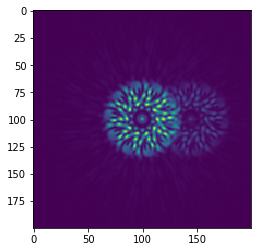

In [762]:
plt.imshow(data)
# plt.show()
plt.savefig("data_2.jpg")

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


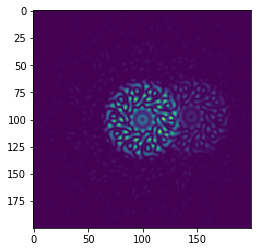

In [766]:
fig = plt.figure()
FT_models = []
for i in range(len(A_vals)):
    im = plt.imshow(models[i], vmin=np.min(models), vmax=np.max(models))
    FT_models.append([im])
    
ani = animation.ArtistAnimation(fig, FT_models, interval=50, blit=True, repeat_delay=1000)

writer = PillowWriter(fps=20)
ani.save("Model.gif", writer='imagemagick')
plt.show()

In [791]:
import matplotlib

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


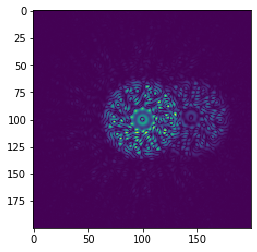

In [801]:
fig = plt.figure()
differences = []
for i in range(len(A_vals)):
#     im = plt.imshow(diffs[i], vmin=np.min(diffs), vmax=np.max(diffs))
    im = plt.imshow(np.abs(diffs[i]), vmin=np.min(0), vmax=np.max(diffs))
    differences.append([im])
    
ani = animation.ArtistAnimation(fig, differences, interval=50, blit=True, repeat_delay=1000)

writer = PillowWriter(fps=20)
ani.save("Diffs.gif", writer='imagemagick')
plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


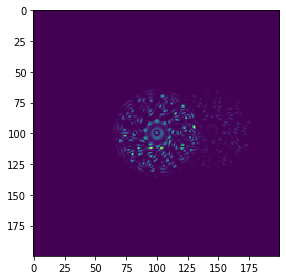

In [799]:
fig = plt.figure()
sqs = []
for i in range(len(A_vals)):
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    im = plt.imshow(squares[i], vmin=np.min(squares), vmax=np.max(squares))
    sqs.append([im])
    
ani = animation.ArtistAnimation(fig, sqs, interval=50, blit=True, repeat_delay=1000)

writer = PillowWriter(fps=20)
ani.save("Squares.gif", writer='imagemagick')
plt.show()

In [567]:
errors_A = [[evaluate_model(data_A[i], build_model([A_val, 16.5, 1])) for A_val in tqdm(A_vals_list[i], leave=False)] for i in tqdm(range(num))]

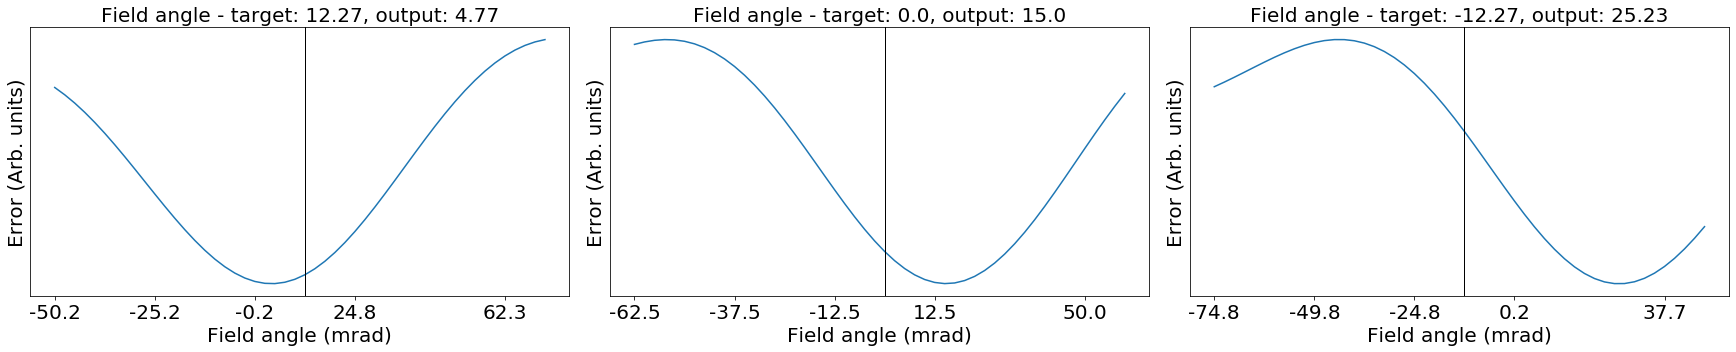

In [826]:
plt.figure(figsize=(40,5))
# for i in range(5):
for i in [1,2,3]:
    plt.subplot(1,5,i+1)
    plt.plot(np.array(errors_A[i])*1e6)
    out_idx = np.where(errors_A[i] == np.min(errors_A[i]))[0][0]
    val_out = np.round(A_vals_list[i][out_idx]*1e3, decimals=2)
    target = np.round(field_angles[i]*1e3, decimals=2)
    plt.title("Field angle - target: {}, output: {}".format(target, val_out), fontsize=20)
    plt.xlabel("Field angle (mrad)", fontsize=20)
    plt.ylabel("Error (Arb. units)", fontsize=20)
    plt.xticks(indexes, np.round(A_ticks_list[i]*1e3, decimals=1), fontsize=20)
    plt.yticks([])
    plt.axvline(x=num_vals//2, color='k', linewidth=1)
    
plt.tight_layout()
plt.savefig("A_Errors")

In [710]:
def make_plot(i):
    plt.plot(np.array(errors_A[2])*1e6)
    out_idx = np.where(errors_A[2] == np.min(errors_A[2]))[0][0]
    val_out = np.round(A_vals_list[2][out_idx]*1e3, decimals=2)
    target = np.round(field_angles[2]*1e3, decimals=2)
    plt.title("Field angle - target: {}, output: {}".format(target, val_out))
    plt.xlabel("Field angle (mrad)")
    plt.ylabel("Error (Arb. units)")
    plt.xticks(indexes, np.round(A_ticks_list[2]*1e3, decimals=2))
    plt.yticks()
    plt.axvline(x=num_vals//2, color='k', linewidth=1)
    plt.axvline(x=i, color='r', linewidth=1)
    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

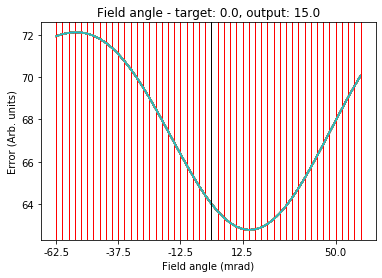

In [712]:
# kwargs_write = {'fps':20., 'quantizer':'nq'}
imageio.mimsave('./errors.gif', [make_plot(i) for i in range(num_vals)], fps=20)

In [728]:
print(A_vals)

[-0.08704369 -0.08454369 -0.08204369 -0.07954369 -0.07704369 -0.07454369
 -0.07204369 -0.06954369 -0.06704369 -0.06454369 -0.06204369 -0.05954369
 -0.05704369 -0.05454369 -0.05204369 -0.04954369 -0.04704369 -0.04454369
 -0.04204369 -0.03954369 -0.03704369 -0.03454369 -0.03204369 -0.02954369
 -0.02704369 -0.02454369 -0.02204369 -0.01954369 -0.01704369 -0.01454369
 -0.01204369 -0.00954369 -0.00704369 -0.00454369 -0.00204369  0.00045631
  0.00295631  0.00545631  0.00795631  0.01045631  0.01295631  0.01545631
  0.01795631  0.02045631  0.02295631  0.02545631  0.02795631  0.03045631
  0.03295631  0.03545631]


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


fig size: 72.0 DPI, size in inches [6. 4.]


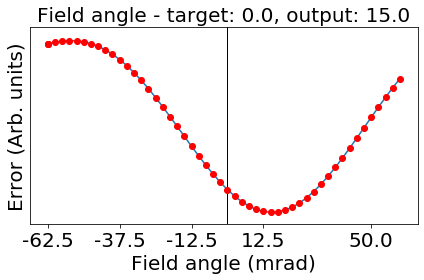

In [815]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
# x = np.arange(0, 20, 0.1)

# ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))

ax.plot(np.array(errors_A[2])*1e6)
out_idx = np.where(errors_A[2] == np.min(errors_A[2]))[0][0]
val_out = np.round(A_vals_list[2][out_idx]*1e3, decimals=2)
target = np.round(field_angles[2]*1e3, decimals=2)
ax.set_title("Field angle - target: {}, output: {}".format(target, val_out), fontsize=20)
ax.set_xlabel("Field angle (mrad)", fontsize=20)
ax.set_ylabel("Error (Arb. units)", fontsize=20)
# ax.set_xticks(indexes, np.round(A_ticks_list[2]*1e3, decimals=2))
# ax.set_xticks(np.round(A_vals_list[2]*1e3, decimals=2))
ax.set_yticks([])
ax.set_ylim(np.min(errors_A[2])*1e6*0.99, np.max(errors_A[2])*1e6*1.01)
ax.axvline(x=num_vals//2, color='k', linewidth=1)
# ax.axvline(x=i, color='r', linewidth=1)
    
# ax.plot(5, errors_A[2][5]*1e6)

def update(i):
#     label = 'timestep {0}'.format(i)
#     print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
#     line.set_ydata(x - 5 + i)
#     ax.set_xlabel(label)
    vals = np.array(errors_A[2])*1e6
    ax.plot(i, vals[i], color='r', marker='o')
    plt.xticks(indexes, np.round(A_ticks_list[2]*1e3, decimals=2), fontsize=20)
    return ax

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, num_vals), interval=50)
# if len(sys.argv) > 1 and sys.argv[1] == 'save':
anim.save('line.gif', dpi=80, writer='imagemagick')
# else:
    # plt.show() will just loop the animation forever.
#     plt.show()

In [816]:
A_shifts = []
for i in range(5):
    out_idx = np.where(errors_A[i] == np.min(errors_A[i]))[0][0]
    val_out = np.round(A_vals_list[i][out_idx]*1e3, decimals=2)
    target = np.round(field_angles[i]*1e3, decimals=2)
    shift = val_out-target
    A_shifts.append(shift)

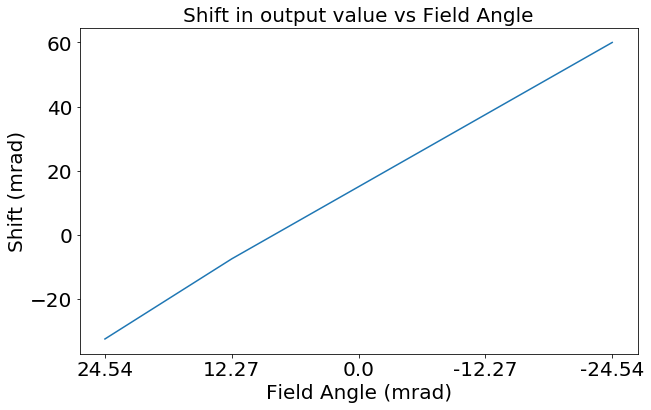

In [819]:
plt.figure(figsize=(10,6))
plt.plot(A_shifts)
plt.title("Shift in output value vs Field Angle", fontsize=20)
plt.xlabel("Field Angle (mrad)", fontsize=20)
plt.ylabel("Shift (mrad)", fontsize=20)
plt.xticks(np.linspace(0, num, num=num, endpoint=False), np.round(field_angles*1e3, decimals=2), fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("A_shift")
plt.show()

---
# Binary seperation testing

In [575]:
resolution_B = 0.05
B_vals_list = []
B_ticks_list = []
for i in tqdm(range(len(data_B)), leave=False):
    target_B = binary_separations[i]
    max_delta_B = num_vals*resolution_B/2
    B_vals = np.linspace(target_B-max_delta_B, target_B+max_delta_B, num=num_vals, endpoint=False) 
    B_vals_list.append(B_vals)
    B_ticks = [B_vals[j] for j in indexes]
    B_ticks_list.append(B_ticks)
    
B_vals_list = np.array(B_vals_list)
B_ticks_list = np.array(B_ticks_list)

In [590]:
errors_B = [[evaluate_model(data_B[i], build_model([0, B_val, 1])) for B_val in tqdm(B_vals_list[i], leave=False)] for i in tqdm(range(num))]

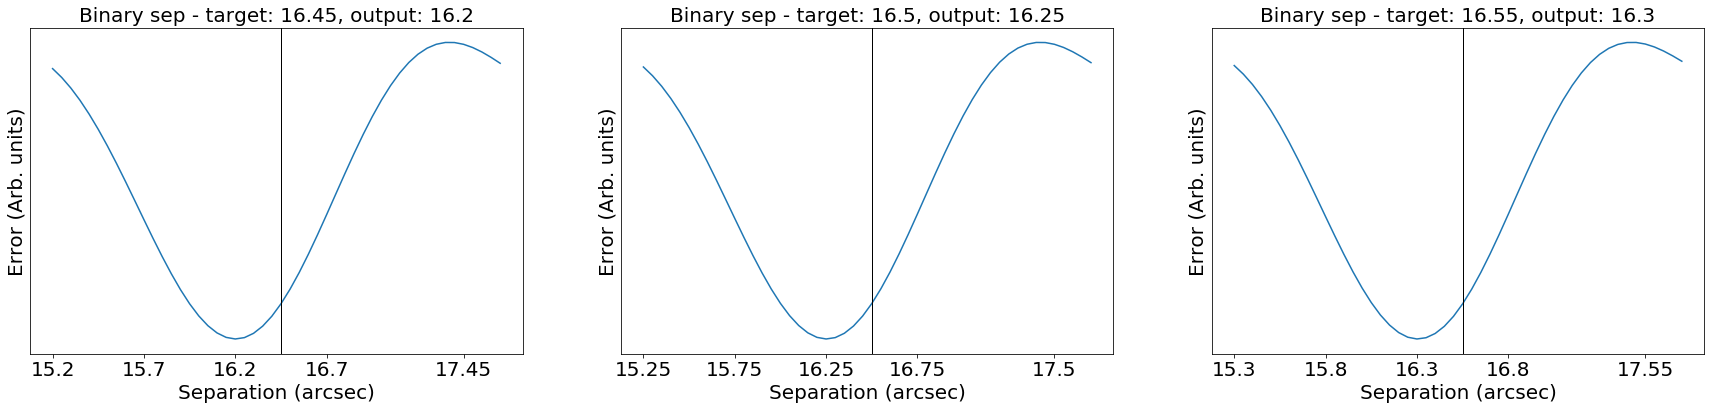

In [850]:
plt.figure(figsize=(30,6))
# for i in range(5):
for i in [1,2,3]:
    plt.subplot(1,3,i)
    plt.plot(np.array(errors_B[i])*1e6)
    out_idx = np.where(errors_B[i] == np.min(errors_B[i]))[0][0]
    val_out = np.round(B_vals_list[i][out_idx], decimals=2)
    target = np.round(binary_separations[i], decimals=2)
    plt.title("Binary sep - target: {}, output: {}".format(target, val_out), fontsize=20)
    plt.xlabel("Separation (arcsec)", fontsize=20)
    plt.ylabel("Error (Arb. units)", fontsize=20)
    plt.xticks(indexes, np.round(B_ticks_list[i], decimals=2), fontsize=20)
    plt.yticks([], fontsize=20)
    plt.axvline(x=num_vals//2, color='k', linewidth=1)
    
plt.savefig("B_Error")

In [578]:
B_shifts = []
for i in range(5):
    out_idx = np.where(errors_B[i] == np.min(errors_B[i]))[0][0]
    val_out = np.round(B_vals_list[i][out_idx]*1e3, decimals=2)
    target = np.round(binary_separations[i]*1e3, decimals=2)
    shift = val_out-target
    B_shifts.append(shift)

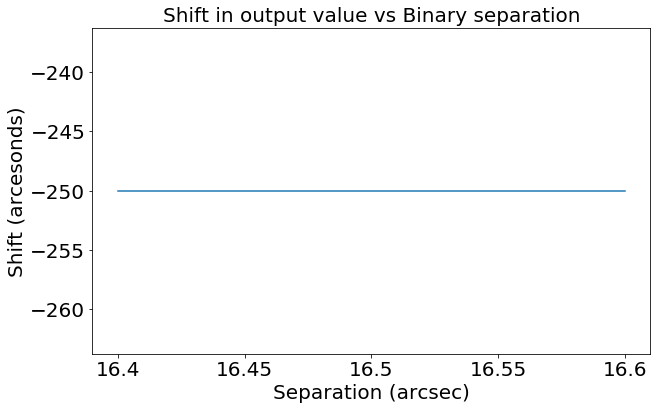

In [834]:
plt.figure(figsize=(10,6))
plt.plot(B_shifts)
plt.title("Shift in output value vs Binary separation", fontsize=20)
plt.xlabel("Separation (arcsec)", fontsize=20)
plt.ylabel("Shift (arcesonds)", fontsize=20)
plt.xticks(np.linspace(0, num, num=num, endpoint=False), np.round(binary_separations, decimals=2), fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("B_shift")
plt.show()

---
# Relative contrast testing

In [580]:
resolution_C = 0.02
C_vals_list = []
C_ticks_list = []

for i in tqdm(range(len(data_C)), leave=False):
    target_C = delta_Cs[i]
    max_delta_C = num_vals*resolution_C/2
    C_vals = np.linspace(target_C-max_delta_C, target_C+max_delta_C, num=num_vals, endpoint=False) 
    C_vals_list.append(C_vals)
    C_ticks = [C_vals[j] for j in indexes]
    C_ticks_list.append(C_ticks)
    
C_vals_list = np.array(C_vals_list)
C_ticks_list = np.array(C_ticks_list)

In [588]:
errors_C = [[evaluate_model(data_C[i], build_model([0, 16.5, C_val])) for C_val in tqdm(C_vals_list[i], leave=False)] for i in tqdm(range(num))]

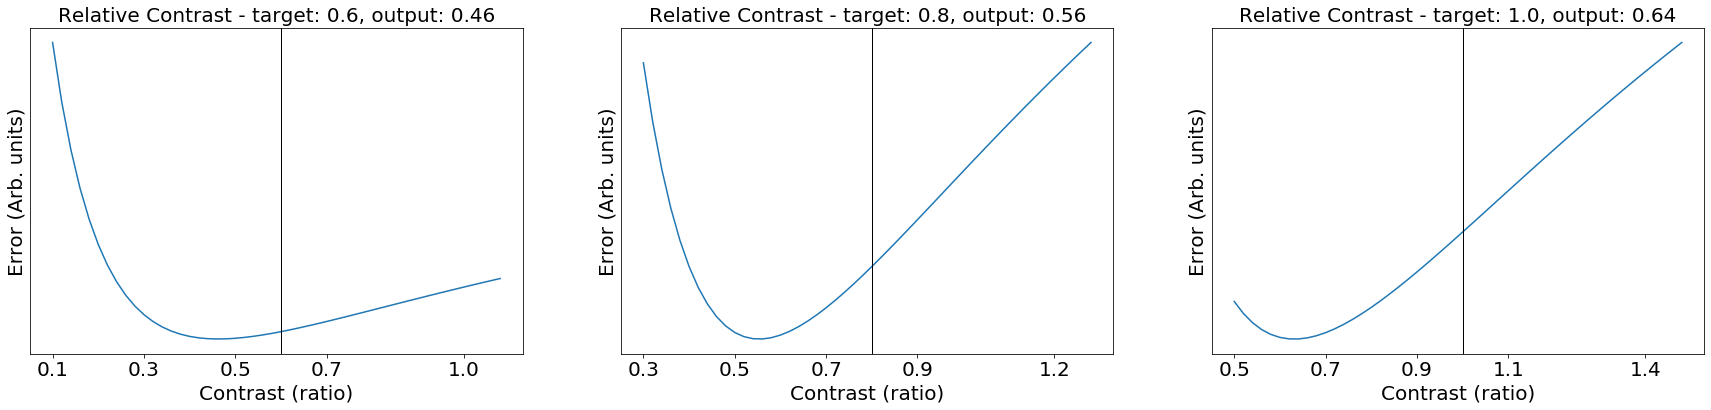

In [852]:
plt.figure(figsize=(30,6))
# for i in range(5):
for i in [0,1,2]:
    plt.subplot(1,3,i+1)
    plt.plot(np.array(errors_C[i]))
    out_idx = np.where(errors_C[i] == np.min(errors_C[i]))[0][0]
    val_out = np.round(C_vals_list[i][out_idx], decimals=2)
    target = np.round(delta_Cs[i], decimals=2)
    plt.title("Relative Contrast - target: {}, output: {}".format(target, val_out), fontsize=20)
    plt.xlabel("Contrast (ratio)", fontsize=20)
    plt.ylabel("Error (Arb. units)", fontsize=20)
    plt.xticks(indexes, np.round(C_ticks_list[i], decimals=2), fontsize=20)
    plt.yticks([], fontsize=20)
    plt.axvline(x=num_vals//2, color='k', linewidth=1)
    
plt.savefig("C_Error")

In [584]:
C_shifts = []
for i in range(5):
    out_idx = np.where(errors_C[i] == np.min(errors_C[i]))[0][0]
    val_out = np.round(C_vals_list[i][out_idx], decimals=2)
    target = np.round(delta_Cs[i], decimals=2)
    shift = val_out-target
    C_shifts.append(shift)

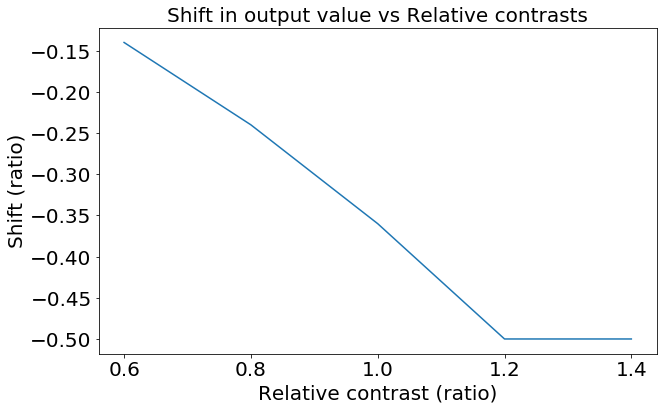

In [843]:
plt.figure(figsize=(10,6))
plt.plot(C_shifts)
plt.title("Shift in output value vs Relative contrasts", fontsize=20)
plt.xlabel("Relative contrast (ratio)", fontsize=20)
plt.ylabel("Shift (ratio)", fontsize=20)
plt.xticks(np.linspace(0, num, num=num, endpoint=False), np.round(delta_Cs, decimals=2), fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("C_shift")
plt.show()

---
## Map the conoutour error plot for A and B

In [601]:
AB_error = np.zeros([A_vals.shape[0], B_vals.shape[0]])
for i in tqdm(range(len(A_vals))):
    for j in range(len(B_vals)):
        AB_error[i][j] = evaluate_model(data_small[2][2], build_model([A_vals[i], B_vals[j], 1]))

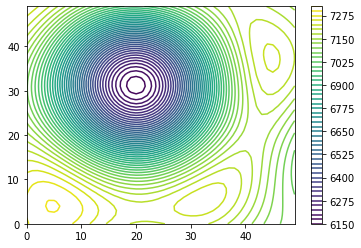

In [139]:
plt.contour(AB_error*1e8, levels=50)
plt.colorbar()
plt.show()

---
Now we want to create a series of these plots for each data point and see if our offset is a constant value for each

In [143]:
num_vals = 25
resolution_A = 2.5e-3
resolution_B = 0.05
error_map = np.zeros([data.shape[0], data.shape[1], num_vals, num_vals])

for i in tqdm(range(len(data_small)), leave=False):
    for j in tqdm(range(len(data_small[i])), leave=False):
        target_A = field_angles[i]
        target_B = binary_separations[j]
        max_delta_A = num_vals*resolution_A/2
        max_delta_B = num_vals*resolution_B/2
        A_vals = np.linspace(target_A-max_delta_A, target_A+max_delta_A, num=num_vals, endpoint=False)
        B_vals = np.linspace(target_B-max_delta_B, target_B+max_delta_B, num=num_vals, endpoint=False) 
        
        for k in tqdm(range(len(A_vals)), leave=False):
            for l in tqdm(range(len(B_vals)), leave=False):
                
                model = build_model([A_vals[k], B_vals[l], 1])
                error = evaluate_model(data_small[i][j], model)
                error_map[i][j][k][l] = error

In [878]:
indexes_emap = np.linspace(0,4,num=5, dtype=np.int)*5

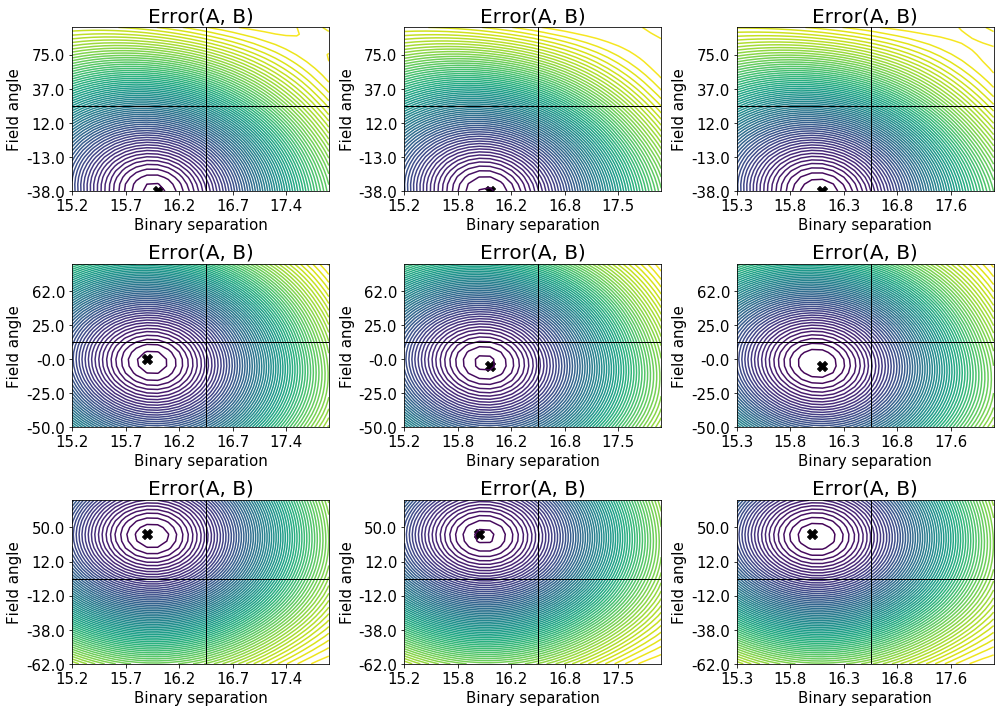

In [896]:
plt.figure(figsize=(14,10))
idx = 1

# for i in range(5):
#     for j in range(5):
        
for i in [0,1,2]:
    
    for j in [1,2,3]:
        
        A_ticks = A_ticks_list[j]
        B_ticks = B_ticks_list[i]
        
        ax = plt.subplot(3, 3, idx)
        plt.contour(error_map[i][j]*1e7, levels=80)
        plt.title("Error(A, B)".format(field_angles[i]*1e3, binary_separations[j]), fontsize=20)
        plt.xlabel("Binary separation", fontsize=15)
        plt.ylabel("Field angle", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
#         plt.colorbar()
        
        plt.xticks(indexes_emap, np.round(B_ticks_list[j], decimals=1))
        plt.yticks(indexes_emap, np.round(A_ticks_list[i]*1e3))
        
        plt.axvline(x=25/2, color='k', linewidth=1)
        plt.axhline(y=25/2, color='k', linewidth=1)
        
        y = np.where(error_map[i][j] == np.min(error_map[i][j]))[0][0]
        x = np.where(error_map[i][j] == np.min(error_map[i][j]))[1][0]
        plt.scatter(x, y, marker='X', c='k', s=100)
        plt.xlim((0, 24))
        plt.ylim((0, 24))
        
        plt.tight_layout()
        
        idx += 1
plt.savefig("Error_map")

---
# Multithreading optimisation

In [104]:
def mult_values(value):
    return 2*value

vals = np.linspace(0,100,1000)
with Pool(5) as p:
    results = p.map(mult_values, vals)

---
## Model Fitting with Least Squares

In [55]:
%%time
offset_A = 3*delta_A*np.random.ranf()
offset_B = 3*delta_B*np.random.ranf()
actual = [field_angles[2], binary_separations[2]]
start = [field_angles[2] + offset_A, binary_separations[2] + offset_B]
out = least_squares(build_model, start)
# out = scipy.optimize.minimize(build_model, start)

CPU times: user 29.8 s, sys: 4.49 s, total: 34.3 s
Wall time: 19.8 s


In [56]:
print(out)

 active_mask: array([0., 0.])
        cost: 2.4319912592391757e+25
         fun: array([6.97422578e+12])
        grad: array([0.00000000e+00, 5.50789698e+16])
         jac: array([[  -0.        , 7897.50311372]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 16
        njev: 1
  optimality: 5.507896978752553e+16
      status: 3
     success: True
           x: array([-0.04580924, 16.59663789])


In [57]:
print("Number of evaluations: {}".format(out.nfev))
print("Target values: A[{}], B[{}]".format(actual[0], actual[1]))
print("Start values: A[{}], B[{}]".format(start[0], start[1]))
print("Output values: A[{}], B[{}]".format(out.x[0], out.x[1]))
print("Error in values: A[{}], B[{}]".format(actual[0] - out.x[0], actual[1] - out.x[1]))

Number of evaluations: 16
Target values: A[0.0], B[16.5]
Start values: A[-0.045809236678343045], B[16.596637893034274]
Output values: A[-0.045809236678343045], B[16.596637893034274]
Error in values: A[0.045809236678343045], B[-0.0966378930342735]
